# Data Cleaning and Preparation

### Import libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shapely as shapely
import geopandas as gpd

### Load Data and Keep Relevant Columns

In [2]:
# Data files
claims_data_file = 'FimaNfipClaims.parquet' #claims data file
metadata_file = 'fima-claims-metadata.csv' #metadata file

# Read metadata to select the features to use
metadata = pd.read_csv(metadata_file)
cols = metadata[metadata['Used in Model'] == 1]['Name'].tolist()

print(f"Columns used in Model:")
cols

Columns used in Model:


['basementEnclosureCrawlspaceType',
 'elevatedBuildingIndicator',
 'elevationDifference',
 'ratedFloodZone',
 'lowestFloorElevation',
 'numberOfFloorsInTheInsuredBuilding',
 'occupancyType',
 'originalConstructionDate',
 'yearOfLoss',
 'buildingDamageAmount',
 'buildingPropertyValue',
 'causeOfDamage',
 'floodCharacteristicsIndicator',
 'floodWaterDuration',
 'waterDepth',
 'countyCode',
 'latitude',
 'longitude']


#### Load and preprocess claims data


In [3]:
# Load the claims data for the selected columns
claims_raw = pd.read_parquet(claims_data_file, columns = cols)

# Drop rows with missing buildingDamageAmount
claims_raw.dropna(subset=['buildingDamageAmount'], inplace=True)
claims_raw = claims_raw[claims_raw['buildingPropertyValue'] > 0]

# Drop rows with missing basementEnclosureCrawlspaceType
claims_raw.dropna(subset=['basementEnclosureCrawlspaceType'], inplace=True)
claims = claims_raw.copy()

# Create Damage Ratio column
claims['damageRatio'] = claims['buildingDamageAmount'] / claims['buildingPropertyValue']
claims.drop(columns=['buildingDamageAmount', 'buildingPropertyValue'], inplace=True)
claims.dropna(subset=['damageRatio'], inplace=True)

# Keep only claims with valid damage ratios
claims['damageRatio'] = claims[(claims['damageRatio'] >=0) & (claims['damageRatio'] <= 1)]['damageRatio']
claims.dropna(subset=['damageRatio'], inplace=True)

# Keep claims with positive water depth
claims = claims[claims['waterDepth'] >= 0].copy()

# Convert water depth from inches to feet
claims['waterDepth'] = claims['waterDepth']/12

In [111]:
gdf = gpd.GeoDataFrame(claims[['longitude', 'latitude', 'damageRatio', 'waterDepth']].copy())
gdf = gdf.set_geometry(gpd.points_from_xy(gdf.longitude, gdf.latitude)).set_crs(epsg=4326)

#### Check features with most missing values 

In [4]:
def missing_value_percent(df):
    """
    Function to calculate the percentage of missing values in each column of a DataFrame.
    """
    return df.isnull().sum().sort_values(ascending=False)/len(claims)*100

# Percentage of missing values
missing_value_percent(claims)

floodCharacteristicsIndicator         99.085645
lowestFloorElevation                  75.544211
elevationDifference                   73.774316
floodWaterDuration                    14.179620
ratedFloodZone                         2.608815
countyCode                             0.651336
longitude                              0.444209
latitude                               0.444209
numberOfFloorsInTheInsuredBuilding     0.058631
occupancyType                          0.017352
causeOfDamage                          0.012786
basementEnclosureCrawlspaceType        0.000000
yearOfLoss                             0.000000
waterDepth                             0.000000
elevatedBuildingIndicator              0.000000
originalConstructionDate               0.000000
damageRatio                            0.000000
dtype: float64

#### Keep columns with missing values < 60%

In [5]:
keep_cols = [col for col in claims.columns if claims[col].isnull().sum() < 0.6*len(claims)]
claims = claims[keep_cols].copy()

print("Columns kept after removing those with more than 60% missing values:")
keep_cols

Columns kept after removing those with more than 60% missing values:


['basementEnclosureCrawlspaceType',
 'elevatedBuildingIndicator',
 'ratedFloodZone',
 'numberOfFloorsInTheInsuredBuilding',
 'occupancyType',
 'originalConstructionDate',
 'yearOfLoss',
 'causeOfDamage',
 'floodWaterDuration',
 'waterDepth',
 'countyCode',
 'latitude',
 'longitude',
 'damageRatio']

### Create derived features

#### Compute `buildingAgeAtLoss`

In [7]:
# Convert originalConstructionDate to year except for null values
claims['originalConstructionDate'] = (claims['originalConstructionDate']
                                        .apply(lambda x: x.year if not pd.isna(x) else x))

# Convert all 1492 construction year to NaN
claims['originalConstructionDate'] = (claims['originalConstructionDate'].replace(1492, np.nan))

# Fill null values with median construction date
median_construction_date = claims['originalConstructionDate'].median()
claims['originalConstructionDate'] = pd.to_numeric(claims['originalConstructionDate'].fillna(median_construction_date))

# Use OriginalConstructionDate and yearOfLoss to calculate buildingAgeAtLoss
claims["buildingAgeAtLoss"] = claims['yearOfLoss'] - claims['originalConstructionDate']
claims['buildingAgeAtLoss'] = claims['buildingAgeAtLoss'].clip(lower=1)

# Drop originalConstructionDate column but keep yearOfLoss column as it may be a useful predictor
claims.drop(columns=['originalConstructionDate'], inplace=True)

### Clean and standardize features

#### Fix `causeOfDamage`

Only allow the following `causeOfDamage` values:

1 : Tidal water overflow; 

2 : Stream, river, or lake overflow; 

3 : Alluvial fan overflow; 

4 : Accumulation of rainfall or snowmelt

Rest all are coded as NaN


In [8]:
# causeOfDamage = 0 means Other Causes, it is better to make it NaN and impute
claims['causeOfDamage'] = claims['causeOfDamage'].replace('0', None)

# Convert causeOfDamage to string
cause_of_damage_values = list(claims['causeOfDamage'].unique())
valid_cause_of_damage = ['1', '2', '3', '4']
invalid_cause_of_damage = [value for value in cause_of_damage_values if value not in valid_cause_of_damage]

# Replace invalid causeOfDamage values with None
claims['causeOfDamage'] = claims['causeOfDamage'].replace(invalid_cause_of_damage, None)

# Add unknown flag for cauge of damage
claims['unknownCauseOfDamage'] = claims['causeOfDamage'].isnull().astype(int)

#### Fix Data Types

In [9]:
claims['countyCode'] = claims['countyCode'].astype(str)

### Handle Unknowns

In [10]:
def impute_missing_values(df: pd.DataFrame, col: str, by: str | list, method: str):
    """
    Function to impute missing values in a DataFrame.
    Parameters:
        df (pd.DataFrame): The DataFrame containing the data.
        col (str): The column with missing values to be imputed.
        by (str | list): The column(s) to group by for imputation.
        method (str): The method to use for imputation ('median', 'mean', 'mode').
    Returns:
        pd.Series: A Series with the imputed values for the specified column.
    """

    #assert df[col].isnull().sum() > 0, f"Column {col} has no missing values"
    assert method in ['median', 'mean', 'mode'], f"Method {method} is not supported"
    
    # Create a DataFrame with only rows where the column is not null
    known_df = df.dropna(subset=col)
    initial_unknowns = df[col].isna().sum()

    # Calculate the imputation map based on the specified method
    if method == 'median':
        impute_map = known_df.groupby(by)[col].median()  
    elif method == 'mean':
        impute_map = known_df.groupby(by)[col].mean()  
    elif method == 'mode':
        impute_map = known_df.groupby(by)[col].agg(lambda x: x.mode()[0])  

    # Define a function to impute missing values based on the group
    def impute_by_group(row):
        if pd.notna(row[col]):  
            return row[col]
        group_key = tuple(row[by]) if isinstance(by, list) else row[by]  
        return impute_map.get(group_key, np.nan)  

    # Apply the imputation function to each row and extract the imputed column
    print(f'Imputing {col} by {by} {method}')
    imputed_column = df.apply(impute_by_group, axis=1)
    unknowns_after_targeted_imputation = imputed_column.isna().sum()
    print(f"\t{initial_unknowns - unknowns_after_targeted_imputation} unknowns were filled with targeted imputation")

    # For remaining unfilled rows, fill by the 'method' over all rows
    if method == 'median':
        fill_value = imputed_column.median()
    elif method == 'mean':
        fill_value = imputed_column.mean()
    elif method == 'mode':
        fill_value = imputed_column.mode()[0]
    
    imputed_column = imputed_column.fillna(fill_value)
    final_unknowns = imputed_column.isna().sum()
    print(f'\t{unknowns_after_targeted_imputation- final_unknowns} were filled by overall {method} ({fill_value})')
    print(f'\t{final_unknowns} unknowns left\n')

    return imputed_column, impute_map

##### Drop unknown `ratedFloodZone` and `countyCode`

In [50]:
# Drop unkown rateFloodZone
claims.dropna(subset = ['ratedFloodZone', 'countyCode'], inplace=True)

In [13]:
example = claims.dropna(subset = ['ratedFloodZone', 'countyCode', 'occupancyType', 'waterDepth', 'floodWaterDuration'])
example

,basementEnclosureCrawlspaceType,elevatedBuildingIndicator,ratedFloodZone,numberOfFloorsInTheInsuredBuilding,occupancyType,yearOfLoss,causeOfDamage,floodWaterDuration,waterDepth,countyCode,latitude,longitude,damageRatio,buildingAgeAtLoss,unknownCauseOfDamage
9,0.0,True,AE,5.0,1.0,2015,4,0.0,0.083333,01001,32.4,-86.4,0.226411,26.0,0
10,0.0,False,AE,1.0,1.0,2009,4,0.0,0.333333,01001,32.5,-86.4,0.003733,31.0,0
11,0.0,False,AE,1.0,1.0,2000,None,0.0,0.000000,01001,32.5,-86.4,0.092600,22.0,1
13,0.0,True,AE,5.0,1.0,2009,2,0.0,0.083333,01001,32.4,-86.4,0.273405,20.0,0
14,0.0,True,AHB,2.0,1.0,2017,2,0.0,0.000000,01001,32.5,-86.5,0.064020,20.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2707093,1.0,False,A13,3.0,1.0,1985,1,0.0,0.083333,None,None,None,0.193982,44.0,0
2707539,1.0,True,AE,2.0,1.0,2007,4,0.0,1.666667,None,18.5,-66.4,0.004882,23.0,0
2707547,2.0,True,A,2.0,2.0,2008,2,0.0,2.333333,None,18.0,-65.9,0.031272,14.0,0
2707972,1.0,False,X,2.0,1.0,2008,4,0.0,0.416667,None,18.4,-66.1,0.004943,8.0,0


##### Impute missing values for categorical columns

In [51]:
claims['occupancyType'] = impute_missing_values(claims, 'occupancyType', 'countyCode', 'mode')[0]

Imputing occupancyType by countyCode mode
	182 unknowns were filled with targeted imputation
	0 were filled by overall mode (1.0)
	0 unknowns left



##### Impute missing values for numerical columns

In [52]:
claims['waterDepth'] = impute_missing_values(claims, 'waterDepth', ['yearOfLoss', 'countyCode'], 'median')[0]
claims['floodWaterDuration'] = impute_missing_values(claims, 'floodWaterDuration', ['yearOfLoss', 'countyCode'], 'median')[0]
claims['numberOfFloorsInTheInsuredBuilding'] = impute_missing_values(claims, 'numberOfFloorsInTheInsuredBuilding', ['occupancyType', 'countyCode'],'median')[0]

Imputing waterDepth by ['yearOfLoss', 'countyCode'] median
	0 unknowns were filled with targeted imputation
	0 were filled by overall median (0.08333333333333333)
	0 unknowns left

Imputing floodWaterDuration by ['yearOfLoss', 'countyCode'] median
	125280 unknowns were filled with targeted imputation
	39202 were filled by overall median (0.0)
	0 unknowns left

Imputing numberOfFloorsInTheInsuredBuilding by ['occupancyType', 'countyCode'] median
	454 unknowns were filled with targeted imputation
	0 were filled by overall median (1.0)
	0 unknowns left



### Code categorical columns

In [79]:
# List categorical columns
categorical_cols = ['ratedFloodZone', 'causeOfDamage', 'occupancyType', 
                    'countyCode', 'elevatedBuildingIndicator', 'unknownCauseOfDamage']
# List numerical columns
numerical_cols = [col for col in claims.columns if col not in categorical_cols]

In [77]:
all_categories = {}
for col in categorical_cols:
    categories = claims[col].to_list()
    categorical_col = pd.Categorical(claims[col])
    codes = categorical_col.codes
    category_map = list(set([(cat,code) for cat, code in zip(categories, codes)]))
    category_map = {cat:code for cat, code in category_map}
    all_categories.update({col: category_map})
    claims[col] = codes

In [72]:
all_categories

{'ratedFloodZone': {70: 70,
  52: 52,
  43: 43,
  61: 61,
  20: 20,
  38: 38,
  29: 29,
  33: 33,
  37: 37,
  39: 39,
  42: 42,
  57: 57,
  2: 2,
  48: 48,
  66: 66,
  34: 34,
  11: 11,
  53: 53,
  30: 30,
  71: 71,
  7: 7,
  16: 16,
  62: 62,
  58: 58,
  25: 25,
  35: 35,
  44: 44,
  26: 26,
  3: 3,
  12: 12,
  21: 21,
  67: 67,
  40: 40,
  22: 22,
  31: 31,
  49: 49,
  8: 8,
  17: 17,
  27: 27,
  68: 68,
  54: 54,
  63: 63,
  36: 36,
  45: 45,
  13: 13,
  32: 32,
  55: 55,
  18: 18,
  64: 64,
  41: 41,
  50: 50,
  59: 59,
  60: 60,
  51: 51,
  4: 4,
  5: 5,
  14: 14,
  23: 23,
  69: 69,
  0: 0,
  9: 9,
  46: 46,
  1: 1,
  24: 24,
  65: 65,
  47: 47,
  10: 10,
  19: 19,
  28: 28,
  6: 6,
  56: 56,
  15: 15},
 'causeOfDamage': {4: 4, 0: 0, 1: 1, 3: 3, 2: 2},
 'occupancyType': {4: 4,
  8: 8,
  5: 5,
  7: 7,
  0: 0,
  9: 9,
  1: 1,
  13: 13,
  10: 10,
  3: 3,
  12: 12,
  2: 2,
  6: 6,
  11: 11},
 'countyCode': {2259: 2259,
  1126: 1126,
  277: 277,
  1957: 1957,
  1108: 1108,
  2788: 278

#### Plot distribution for all variables

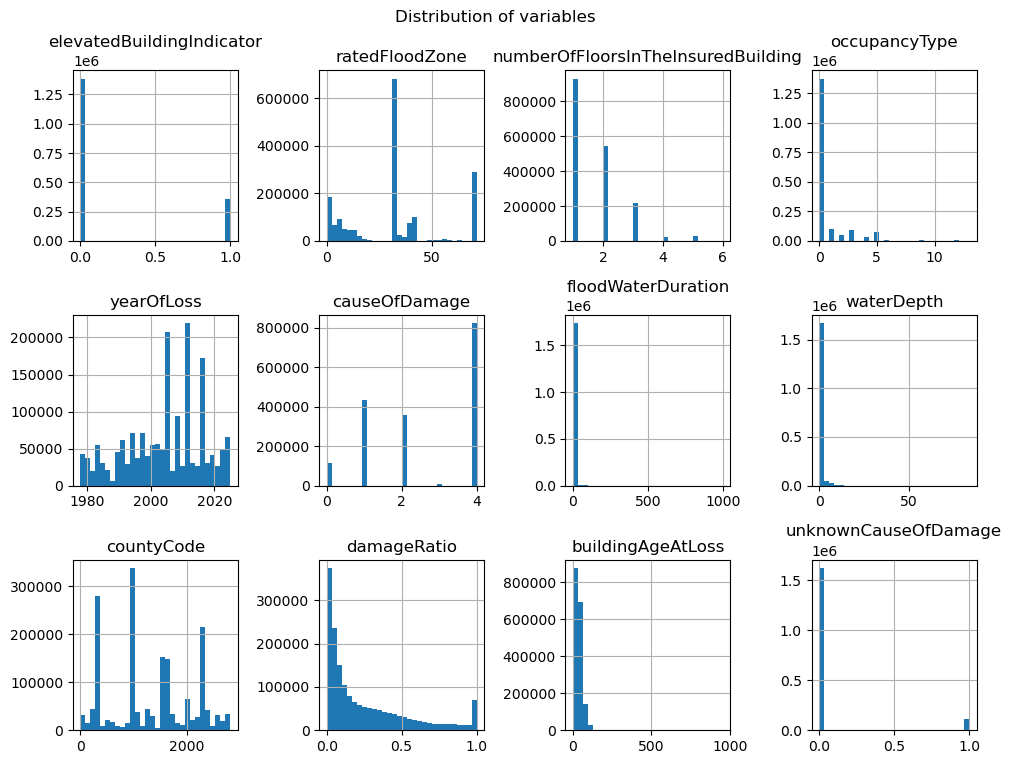

In [81]:
plt.figure(figsize = (10,10))
num_plots = len(claims.columns)
dim = int(np.ceil(np.sqrt(num_plots)))
i = 0
for col in claims.columns:
        i+=1
        plt.subplot(dim, dim, i)
        plt.grid()
        plt.hist(claims[col], bins = 30)
        plt.title(col)
plt.suptitle('Distribution of variables')
plt.tight_layout()


### Final Data

#### Save cleaned claims data

In [83]:
claims.to_csv('claims_cleaned.csv', index = False)